<a href="https://colab.research.google.com/github/Abdelmenam-Tarek-Abdelmenam/Face-mask_detection/blob/main/mask_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import packeges

In [17]:
from tensorflow.keras.applications import MobileNetV2
import  tensorflow.keras.layers as layer 
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import tensorflow.keras.preprocessing.image as imagePros
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
%matplotlib inline  
sns.set()

# Initial values

In [18]:
initialLearningRate = 1e-4
numberOfEpochs = 20
batchSize = 32

dataDirectory = r"drive/MyDrive/Colab Notebooks/dataset"
categories = ["with_mask", "without_mask"]

# the list of data 
data = []
labels = []

# Read images

In [19]:
for category in categories:
    path = os.path.join(dataDirectory, category)
    for img in os.listdir(path):
    	img_path = os.path.join(path, img)
    	image = imagePros.load_img(img_path, target_size=(224, 224))
    	image = imagePros.img_to_array(image)
    	image = preprocess_input(image)

    	data.append(image)
    	labels.append(category)
     

labelCount = {i:labels.count(i) for i in labels}
print("number of images", len(data))
print(labelCount)

number of images 3842
{'with_mask': 1924, 'without_mask': 1918}


#  Encode the labels

In [20]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels) #vector to matrix 0-1

#Split data

In [21]:
data = np.array(data, dtype="float32")
labels = np.array(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

print("tarin data lenght" , len(trainX))
print("test data lenght" , len(testX))

tarin data lenght 3073
test data lenght 769


#Data augmentation

In [22]:
aug = imagePros.ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

#Prepare model

In [ ]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=layer.Input(shape=(224, 224, 3)))

headModel = baseModel.output
headModel = layer.AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = layer.Flatten(name="flatten")(headModel)
headModel = layer.Dense(128, activation="relu")(headModel)
headModel = layer.Dropout(0.5)(headModel)
headModel = layer.Dense(2, activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
	layer.trainable = False # freeze hidden model

#Model training

In [27]:
opt = Adam(lr=initialLearningRate, decay=initialLearningRate / numberOfEpochs)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

H = model.fit(
	aug.flow(trainX, trainY, batch_size=batchSize),
	steps_per_epoch=len(trainX) // batchSize,
	validation_data=(testX, testY),
	validation_steps=len(testX) // batchSize,
	epochs=numberOfEpochs)

Epoch 1/20
96/96 [==============================] - 151s 2s/step - loss: 0.0971 - accuracy: 0.9744 - val_loss: 0.0631 - val_accuracy: 0.9805
Epoch 2/20
96/96 [==============================] - 142s 1s/step - loss: 0.0698 - accuracy: 0.9819 - val_loss: 0.0521 - val_accuracy: 0.9818
Epoch 3/20
96/96 [==============================] - 151s 2s/step - loss: 0.0558 - accuracy: 0.9849 - val_loss: 0.0461 - val_accuracy: 0.9857
Epoch 4/20
96/96 [==============================] - 143s 1s/step - loss: 0.0481 - accuracy: 0.9872 - val_loss: 0.0420 - val_accuracy: 0.9870
Epoch 5/20
96/96 [==============================] - 142s 1s/step - loss: 0.0450 - accuracy: 0.9885 - val_loss: 0.0435 - val_accuracy: 0.9805
Epoch 6/20
96/96 [==============================] - 143s 1s/step - loss: 0.0438 - accuracy: 0.9882 - val_loss: 0.0471 - val_accuracy: 0.9766
Epoch 7/20
96/96 [==============================] - 144s 1s/step - loss: 0.0350 - accuracy: 0.9882 - val_loss: 0.0370 - val_accuracy: 0.9857
Epoch 8/20
96

#Model testing

In [28]:
predIdxs = model.predict(testX, batch_size=batchSize)

predIdxs = np.argmax(predIdxs, axis=1)

print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.99      0.99      0.99       385
without_mask       0.99      0.99      0.99       384

    accuracy                           0.99       769
   macro avg       0.99      0.99      0.99       769
weighted avg       0.99      0.99      0.99       769



#Save model

In [29]:
model.save("mask_detector.model", save_format="h5")

#Plot reasults

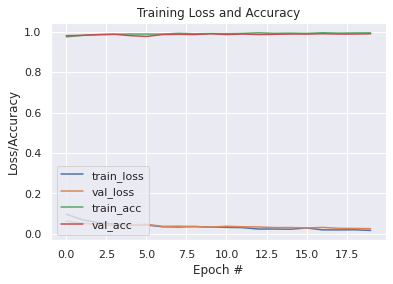

<Figure size 432x288 with 0 Axes>

In [30]:
N = numberOfEpochs
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()
plt.savefig("results.png")